<a href="https://colab.research.google.com/github/MVadia/Biomechanical-Analysis-Program/blob/main/tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#dl models
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
from tensorflow.keras.layers import LSTM
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf



In [ ]:
#Download dataset

# Alam, N.A. (2024) Phishing Email Dataset Available from https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset.
emailDF1 = pd.read_csv('Phishing_Email.csv')

emailDF1.head()
emailDF1.drop(columns=['Unnamed: 0'], inplace=True)
emailDF1.describe()
print(emailDF1['Email Type'].value_counts())


Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64


In [ ]:
#Download dataset 2

#Singhvi, P. (n.d.) Spam Email Classification Dataset Available from https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset.

emailDF2 = pd.read_csv('combined_data.csv')

emailDF2.head()
print(emailDF2['label'].value_counts())

label
1    43910
0    39538
Name: count, dtype: int64


In [ ]:
print (emailDF1.columns)
print (emailDF2.columns)

Index(['Email Text', 'Email Type'], dtype='object')
Index(['label', 'text'], dtype='object')


In [ ]:
emailDF2.rename(columns={'text': 'Email Text'}, inplace=True)

In [ ]:
print(emailDF2.columns)

Index(['label', 'Email Text'], dtype='object')


In [ ]:
#combine the datasets
emailDF2['Email Type'] = emailDF2['label'].map({1: 'Phishing Email', 0: 'Safe Email'})

#drop old label column
emailDF2.drop(columns=['label'], inplace=True)

#concat both sets
email_datasetDF = pd.concat([emailDF1, emailDF2], ignore_index=True)

#check
print(email_datasetDF['Email Type'].value_counts())

email_datasetDF.head()

Email Type
Phishing Email    51238
Safe Email        50860
Name: count, dtype: int64


,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [ ]:
email_datasetDF.describe()

,Email Text,Email Type
count,102082,102098
unique,100982,2
top,empty,Phishing Email
freq,533,51238


In [ ]:
email_datasetDF.dropna(subset=['Email Text'], inplace=True)
email_datasetDF.drop_duplicates(subset='Email Text', inplace=True)
email_datasetDF.describe()
print(email_datasetDF['Email Type'].value_counts())

Email Type
Safe Email        50517
Phishing Email    50465
Name: count, dtype: int64


In [ ]:

#Data cleaning
#Remove rows with missing Email Text
email_datasetDF.dropna(subset=['Email Text'], inplace=True)
email_datasetDF.describe()

#Drop duplicates based on Email Text
email_datasetDF.drop_duplicates(subset='Email Text', inplace=True)
email_datasetDF.describe()


#Encode email type (target) as numerical values
#Phishing: 1
#Safe: 0
email_datasetDF['Email Type'] = email_datasetDF['Email Type'].apply(lambda x: 1 if x == 'Phishing Email' else 0)

#check df
#print(email_datasetDF.info())
print(email_datasetDF['Email Type'].value_counts())
email_datasetDF.info()

#extract URL function
def extract_URL(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.findall(text)

#apply url extraction
email_datasetDF['URLs'] = email_datasetDF['Email Text'].apply(extract_URL)

#count url as feature
email_datasetDF['URL Count'] = email_datasetDF['URLs'].apply(len)

#removeurls from email text
email_datasetDF['Email Text'] = email_datasetDF['Email Text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x))

#function to clean text
def clean_text(text):
    #lowercase
    text = text.lower()
    #remove special characters
    text = re.sub(r'[^a-z\s]', '', text)
    #remove whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    #remove stopwords
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

#apply clean text
email_datasetDF['Cleaned Text'] = email_datasetDF['Email Text'].apply(clean_text)

#check
print(email_datasetDF[['Email Text', 'URLs', 'URL Count', 'Cleaned Text']])

Email Type
0    10979
1     6558
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 17537 entries, 0 to 18648
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  17537 non-null  object
 1   Email Type  17537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 411.0+ KB
                                              Email Text  \
0      re : 6 . 1100 , disc : uniformitarianism , re ...   
1      the other side of * galicismos * * galicismo *...   
2      re : equistar deal tickets are you still avail...   
3      \nHello I am your hot lil horny toy.\n    I am...   
4      software at incredibly low prices ( 86 % lower...   
...                                                  ...   
18644  \nRick Moen  a Ã©crit:> > I'm confused. I thou...   
18645  date a lonely housewife always wanted to date ...   
18646  request submitted : access request for anita ....   
18647  re : important - pr

In [ ]:
#Extract Features
#function to count words
def count_words(text):
    return len(text.split())

#function to count special characters
def count_chars(text):
    return sum(1 for char in text if not char.isalnum() and not char.isspace())

#function to count characters
def count_chars(text):
    return len(text)

#function to count digits
def count_digits(text):
    return sum([1 for char in text if char.isdigit()])

#function to get average word length
def avg_word_length(text):
    words = text.split()
    return sum(len(word) for word in words)/len(words) if len(words) > 0 else 0

#function to count keywords
def count_keywords(text, keywords):
    return sum(1 for word in text.split() if word in keywords)

#phishing keywords
spam_keywords = ['urgent', 'bank', 'login', 'verify', 'account', 'password', 'click', 'link']

#apply feature extraction
email_datasetDF['Word Count'] = email_datasetDF['Cleaned Text'].apply(count_words)
email_datasetDF['Char Count'] = email_datasetDF['Email Text'].apply(count_chars)
email_datasetDF['Special Char Count'] = email_datasetDF['Email Text'].apply(count_chars)
email_datasetDF['Digit Count'] = email_datasetDF['Email Text'].apply(count_digits)
email_datasetDF['Average Word Length'] = email_datasetDF['Email Text'].apply(avg_word_length)
email_datasetDF['Spam Keyword Count'] = email_datasetDF['Cleaned Text'].apply(lambda x: count_keywords(x, spam_keywords))

#url based features
email_datasetDF['Suspicious URL Count'] = email_datasetDF['URLs'].apply(lambda urls: sum(1 for url in urls if any(k in url for k in ['login', 'verify', 'secure'])))
email_datasetDF['Shortened URL Count'] = email_datasetDF['URLs'].apply(lambda urls: sum(1 for url in urls if any(s in url for s in ['bit.ly', 't.co', 'tinyurl'])))

#combined features
email_datasetDF['URL to Word Ratio'] = email_datasetDF['URL Count'] / (email_datasetDF['Word Count'] + 1)
email_datasetDF['Special Char to Word Ratio'] = email_datasetDF['Special Char Count'] / (email_datasetDF['Word Count'] + 1)

#check
email_datasetDF.head()



,Email Text,Email Type,URLs,URL Count,Cleaned Text,Word Count,Char Count,Special Char Count,Digit Count,Average Word Length,Spam Keyword Count,Suspicious URL Count,Shortened URL Count,URL to Word Ratio,Special Char to Word Ratio
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0,[],0,disc uniformitarianism sex lang dick hudson s ...,76,1030,1030,9,3.482609,0,0,0,0.000000,13.376623
1,the other side of * galicismos * * galicismo *...,0,[],0,galicismos galicismo spanish term names improp...,36,479,479,0,4.274725,0,0,0,0.000000,12.945946
2,re : equistar deal tickets are you still avail...,0,[],0,equistar deal tickets available assist robert ...,115,1245,1245,63,3.085246,0,0,0,0.000000,10.732759
3,\nHello I am your hot lil horny toy.\n I am...,1,[http://www.mail.com/?sr=signup],1,hello hot lil horny toy dream open minded pers...,42,658,658,29,5.242105,0,0,0,0.023256,15.302326
4,software at incredibly low prices ( 86 % lower...,1,[],0,software incredibly low prices lower drapery s...,54,441,441,2,3.857143,0,0,0,0.000000,8.018182


In [ ]:
#Label data

#split into features and target
X = email_datasetDF.drop(columns=['Email Type'])
y = email_datasetDF['Email Type']

#process text data using tfidf
vectorizer = TfidfVectorizer(max_features=5000)
text_features = vectorizer.fit_transform(X['Cleaned Text']).toarray()

#combine text features with other features
numerical_features = X[['Word Count', 'URL Count', 'Special Char Count', 'Digit Count', 'Average Word Length', 'Spam Keyword Count', 'Suspicious URL Count', 'Shortened URL Count', 'URL to Word Ratio', 'Special Char to Word Ratio']]
final_features = np.hstack((text_features, numerical_features.values)) #combine text and numerical features

#split data into train, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(final_features, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#check
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (12275, 5010), (12275,)
Validation set: (2631, 5010), (2631,)
Test set: (2631, 5010), (2631,)


In [ ]:
#Initial model comparison

#sebset the data
X_subset, _, y_subset, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42)  # Use 30% of training data

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

#dict to store models
models = {
    "Logistic Regression": LogisticRegression(max_iter = 5000, random_state = 42),
    "Random Forest": RandomForestClassifier(n_estimators = 100, random_state = 42),
    "Support Vector Machine": LinearSVC(random_state = 42, max_iter=2000),
    "Naive Bayes": MultinomialNB()
}

#param grid for all models
param_grid = {
    "Logistic Regression": {"C": [ 0.1, 1, 10, 15], "solver" : ['liblinear', 'lbfgs']},
    "Random Forest" : {"n_estimators": [50, 100], "max_depth": [None, 10, 20], "min_samples_split": [2,5], "min_samples_leaf" : [1,2]},
    "Support Vector Machine": {"C": [0.1, 1, 10], "penalty": ["l1", "l2"]},
    "Naive Bayes": {}
}


#dict to store results
grid_results = {}

#loop through models
for model_name, model in models.items():
    print(f"\nPerforming Grid Search for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid[model_name],
        scoring=scoring,
        refit='accuracy',  # Optimize for accuracy, but store all metrics
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_subset, y_subset)

    # Store results for each metric
    grid_results[model_name] = {
        "best_params": grid_search.best_params_,
        "best_accuracy": grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_],
        "best_precision": grid_search.cv_results_['mean_test_precision'][grid_search.best_index_],
        "best_recall": grid_search.cv_results_['mean_test_recall'][grid_search.best_index_],
        "best_f1": grid_search.cv_results_['mean_test_f1'][grid_search.best_index_]
    }
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Metrics for {model_name}: {grid_results[model_name]}")



Performing Grid Search for Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters for Logistic Regression: {'C': 15, 'solver': 'lbfgs'}
Best Metrics for Logistic Regression: {'best_params': {'C': 15, 'solver': 'lbfgs'}, 'best_accuracy': 0.9679506371305528, 'best_precision': 0.9679337520266328, 'best_recall': 0.9679506371305528, 'best_f1': 0.9679306794872595}

Performing Grid Search for Random Forest...
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Metrics for Random Forest: {'best_params': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, 'best_accuracy': 0.957088446109374, 'best_precision': 0.9572186066464553, 'best_recall': 0.957088446109374, 'best_f1': 0.9569666471054303}

Performing Grid Search for Support Vector Machine...
Best Parameters for Support Vector Machine: {'C': 1, 'penalty': 'l1'}
Best Metrics for Support Vector Machine: {'best_params': {'C': 1, 'penalty': 'l1'}, 'best_accuracy': 0.9554605922954398, 'best_precision'

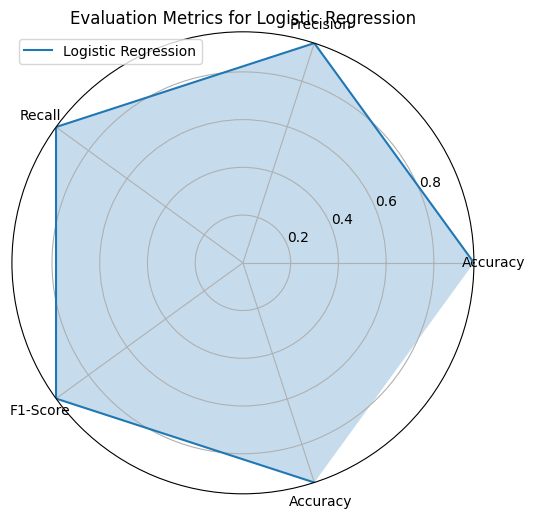

In [ ]:
results_df = pd.DataFrame([
    {
        "Model": model,
        "Best Params": grid_results[model]["best_params"],
        "Accuracy": grid_results[model]["best_accuracy"],
        "Precision": grid_results[model]["best_precision"],
        "Recall": grid_results[model]["best_recall"],
        "F1-Score": grid_results[model]["best_f1"]
    }
    for model in grid_results
])

results_df

from math import pi
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Example: Radar chart for Logistic Regression
model_name = "Logistic Regression"
values = [
    grid_results[model_name]["best_accuracy"],
    grid_results[model_name]["best_precision"],
    grid_results[model_name]["best_recall"],
    grid_results[model_name]["best_f1"]
]
metrics.append(metrics[0])  # Repeat first metric for circular plot
values.append(values[0])

# Create radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
angles = np.linspace(0, 2 * pi, len(metrics), endpoint=False)
ax.plot(angles, values, label=model_name)
ax.fill(angles, values, alpha=0.25)
ax.set_xticks(angles)
ax.set_xticklabels(metrics)
ax.set_title(f"Evaluation Metrics for {model_name}")
ax.legend()
plt.show()


In [ ]:
results_df

,Model,Best Params,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,"{'C': 15, 'solver': 'lbfgs'}",0.967951,0.967934,0.967951,0.967931
1,Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.957088,0.957219,0.957088,0.956967
2,Support Vector Machine,"{'C': 1, 'penalty': 'l1'}",0.955461,0.955426,0.955461,0.955313
3,Naive Bayes,{},0.745790,0.771243,0.745790,0.750187


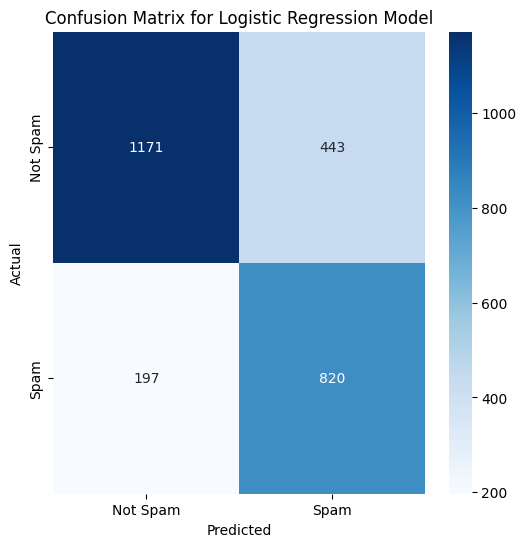

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
best_lr_model = grid_search.best_estimator_
y_pred = best_lr_model.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix for Logistic Regression Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.show()



In [ ]:
# DL models
#prep data
X_text = email_datasetDF['Cleaned Text'].astype(str)

X_text_train, X_text_temp, y_train, y_temp = train_test_split(X_text, y, test_size=0.3, random_state=42)
X_text_val, X_text_test, y_val, y_test = train_test_split(X_text_temp, y_temp, test_size=0.5, random_state=42)


#tokenize text
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_text_train.tolist()) #fit tokenizer on training data

#convert text to sequence
X_train_seq = tokenizer.texts_to_sequences(X_text_train.tolist())
X_val_seq = tokenizer.texts_to_sequences(X_text_val.tolist())
X_test_seq = tokenizer.texts_to_sequences(X_text_test.tolist())

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

#Standardize numerical features separately
from sklearn.preprocessing import StandardScaler

numerical_features = email_datasetDF[['Word Count', 'URL Count', 'Special Char Count', 'Digit Count',
                                      'Average Word Length', 'Spam Keyword Count', 'Suspicious URL Count',
                                      'Shortened URL Count', 'URL to Word Ratio', 'Special Char to Word Ratio']].fillna(0)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

#combine tokenized text + numerical features
X_train_final = np.hstack((X_train_padded, numerical_features_scaled[:len(X_train_padded)]))
X_val_final = np.hstack((X_val_padded, numerical_features_scaled[len(X_train_padded):len(X_train_padded) + len(X_val_padded)]))
X_test_final = np.hstack((X_test_padded, numerical_features_scaled[len(X_train_padded) + len(X_val_padded):]))

#check final shapes
print(f"Training set: {X_train_final.shape}, {y_train.shape}")
print(f"Validation set: {X_val_final.shape}, {y_val.shape}")
print(f"Test set: {X_test_final.shape}, {y_test.shape}")


Training set: (12275, 210), (12275,)
Validation set: (2631, 210), (2631,)
Test set: (2631, 210), (2631,)


In [ ]:
#build fnn

#define fnn model
fnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

#compile model
fnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

#train model
history = fnn_model.fit(X_train_final, y_train, validation_data=(X_val_final, y_val), epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7985 - loss: 0.3872 - val_accuracy: 0.9780 - val_loss: 0.0624
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9939 - loss: 0.0211 - val_accuracy: 0.9761 - val_loss: 0.0717
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9964 - loss: 0.0104 - val_accuracy: 0.9529 - val_loss: 0.1608
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9959 - loss: 0.0152 - val_accuracy: 0.9749 - val_loss: 0.1016
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.9715 - val_loss: 0.1279
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9998 - loss: 8.6949e-04 - val_accuracy: 0.9730 - val_loss: 0.1230
Epoch 7/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9677 - val_loss: 0.1411
Epoch 8/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9975 - loss: 0.0066 - val_accuracy:

In [ ]:
#buld lstm

#define lstm
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

#compile
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

#train
history = lstm_model.fit(X_train_final, y_train, validation_data=(X_val_final, y_val), epochs=10, batch_size=32)

Epoch 1/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 79s 191ms/step - accuracy: 0.6245 - loss: 0.6642 - val_accuracy: 0.6499 - val_loss: 0.6428
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 72s 188ms/step - accuracy: 0.6536 - loss: 0.6478 - val_accuracy: 0.6906 - val_loss: 0.6038
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 78s 204ms/step - accuracy: 0.7065 - loss: 0.5863 - val_accuracy: 0.8776 - val_loss: 0.3009
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 71s 185ms/step - accuracy: 0.9407 - loss: 0.1965 - val_accuracy: 0.9681 - val_loss: 0.0979
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 71s 184ms/step - accuracy: 0.9824 - loss: 0.0622 - val_accuracy: 0.9753 - val_loss: 0.0836
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 71s 184ms/step - accuracy: 0.9923 - loss: 0.0303 - val_accuracy: 0.9772 - val_loss: 0.0876
Epoch 7/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 71s 184ms/step - accuracy: 0.9949 - loss: 0.0197 - val_accuracy: 0.9742 - val_loss: 0.0966
Epoch 8/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 71s 185ms/step - accuracy: 0.9969 - loss: 0

In [ ]:
#using transformer
from transformers import AdamW
#load BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

#tokenize for BERT
train_encodings = bert_tokenizer(X_text_train.tolist(), truncation=True, padding=True, max_length = 128)
val_encodings = bert_tokenizer(X_text_val.tolist(), truncation=True, padding=True, max_length=128)

#convert to tf dataset
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train.tolist())) \
    .shuffle(10000).batch(32).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val.tolist())) \
    .batch(32).prefetch(AUTOTUNE)



#load pretrained model
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

#compile model

bert_model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

#train model
history = bert_model.fit(train_dataset, validation_data=val_dataset, epochs=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
384/384 [==============================] - 4992s 13s/step - loss: 0.6877 - accuracy: 0.5972 - val_loss: 0.6570 - val_accuracy: 0.6378
Epoch 2/3
384/384 [==============================] - 4935s 13s/step - loss: 0.6856 - accuracy: 0.5952 - val_loss: 0.6547 - val_accuracy: 0.6378
Epoch 3/3
384/384 [==============================] - 4887s 13s/step - loss: 0.6879 - accuracy: 0.5938 - val_loss: 0.7465 - val_accuracy: 0.3622
